<a href="https://colab.research.google.com/github/angmr7/FSR_UNO/blob/master/Diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and utility functions

In [2]:
#@title
! pip install celluloid
import math
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
import functools
import sklearn.datasets
# For plotting
from IPython.display import HTML
from base64 import b64encode

In [3]:
#@title
# Utility function for displaying video inline in colab

def show_video(vname):
  mp4 = open(vname,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

def save_animation(vname, interval=30):
  anim = camera.animate(blit=True, interval=interval)
  anim.save(vname)

# Utility function for random noise
def noise_like(shape):
  return tf.random.normal(shape=shape, dtype=tf.float32)

## Data distribution


In [49]:
# Generate points only centered at the origin [0,0]
# Using random normal distribution around this center

num_samples = 1  # You can adjust this if you want more samples
stddev = 0.1

# Directly generate points around the origin
train_data_tf = tf.random.normal(shape=(num_samples, 2),
                                stddev=stddev,
                                mean=[0, 0],
                                dtype=tf.float32)

print(f'{train_data_tf.shape[0]} samples of {train_data_tf.shape[1]} dimensions in training data')

1 samples of 2 dimensions in training data


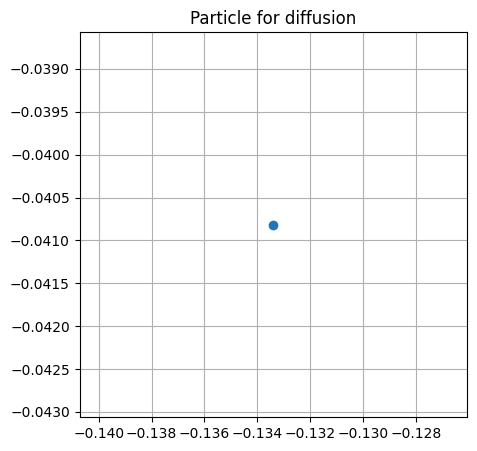

In [48]:
#@title
# Visualize the data
plt.figure(figsize=[5,5])
plt.scatter(train_data_tf[:,0], train_data_tf[:,1])
# for center in centers.numpy():
#   # print(center[0], center[1])
#   plt.scatter([center[0]], [center[1]], marker='x', color='r')
plt.title('Particle for diffusion')
plt.grid()

## Beta schedule

Now that we have the original (non noisy) data, let's start now with the actual diffusion implementation. The first thing is to add noise to the input images following a fixed variance schedule (also known as beta schedule). The original paper uses a linear schedule. And 1000 timesteps to move forward and back. We use smaller number of timesteps (250) as the data is simpler in our case.

In [18]:
num_diffusion_timesteps=250
beta_start=0.0001
beta_end=0.02
schedule_type='linear'

def get_beta_schedule(schedule_type, beta_start, beta_end, num_diffusion_timesteps):
  if schedule_type == 'quadratic':
    betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps, dtype=np.float32) ** 2
  elif schedule_type == 'linear':
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float32)
  return betas

betas_linear = get_beta_schedule('linear', beta_start, beta_end, num_diffusion_timesteps)
betas_quad = get_beta_schedule('quadratic', beta_start, beta_end, num_diffusion_timesteps)

### Visualize beta schedules

The below plot shows that the variance of noise is low at the start and increases as we move forward in time.

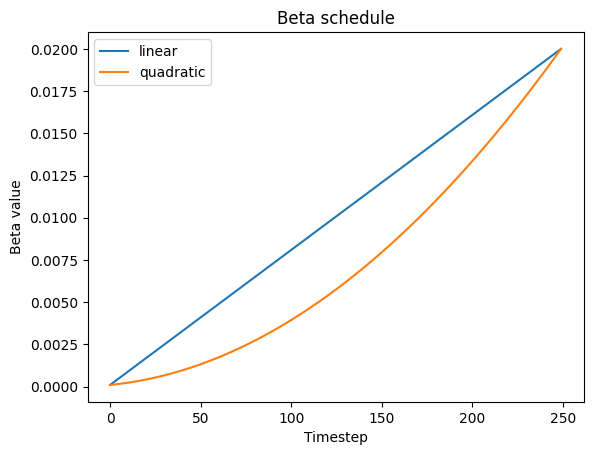

In [50]:
#@title

plt.plot(betas_linear, label = 'linear')
plt.plot(betas_quad, label='quadratic')
plt.title('Beta schedule')
plt.ylabel('Beta value')
plt.xlabel('Timestep')
plt.legend()

### Beta derivatives

Next, let's compute all the derivatives from beta that are used repeatedly in the forward and reverse process of diffusion. Since the variance schedule ($\beta_t$) is fixed, the derivatives of $\beta_t$ are also fixed. We precompute these to save time/ compute.

We'll see the use cases of these variables in the respective sections below.

In [20]:
class BetaDerivatives():
  def __init__(self, betas, dtype=tf.float32):
    """Take in betas and pre-compute the dependent values to use in forward/ backward pass.

    Values are precomputed for all timesteps so that they can be used as and
    when required.
    """
    self.np_betas = betas
    timesteps, = betas.shape
    self.num_timesteps = int(timesteps)

    self.betas = tf.constant(betas, dtype=dtype)
    self.alphas = tf.subtract(1., betas)
    self.alphas_cumprod = tf.math.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = tf.concat([tf.constant([1.0]), self.alphas_cumprod[:-1]], axis=0)

    # calculations required for diffusion q(x_t | x_{t-1}) and others
    self.sqrt_alphas_cumprod = tf.math.sqrt(self.alphas_cumprod)
    self.sqrt_one_minus_alphas_cumprod = tf.math.sqrt(1. - self.alphas_cumprod)
    self.log_one_minus_alphas_cumprod = tf.math.log(1. - self.alphas_cumprod)




  def _gather(self, a, t):
    """
    Utility function to extract some coefficients at specified timesteps,
    then reshape to [batch_size, 1] for broadcasting.
    """
    return tf.reshape(tf.gather(a, t), [-1, 1])

In [21]:
gdb = BetaDerivatives(betas_linear)

### Visualize beta derivatives over time

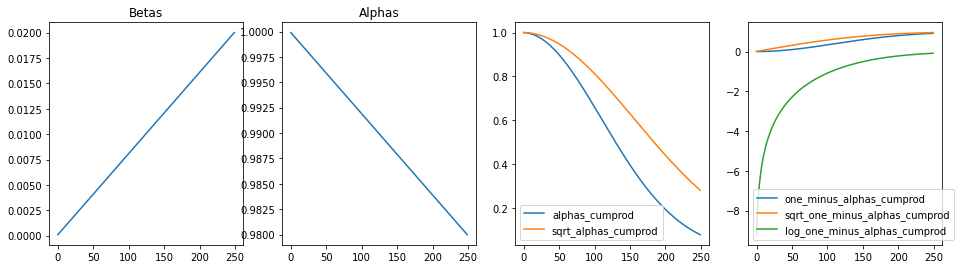

In [ ]:
#@title
# Visualizing betas and other variables
plt.figure(figsize=(16, 9))

plt.subplot(2,4,1)
plt.plot(gdb.betas)
plt.title('Betas')
plt.subplot(2,4,2)
plt.plot(gdb.alphas)
plt.title('Alphas')

plt.subplot(2,4,3)
plt.plot(gdb.alphas_cumprod, label='alphas_cumprod')
plt.plot(gdb.sqrt_alphas_cumprod, label='sqrt_alphas_cumprod')
plt.legend();
plt.subplot(2,4,4)
plt.plot(1-gdb.alphas_cumprod, label='one_minus_alphas_cumprod')
plt.plot(gdb.sqrt_one_minus_alphas_cumprod, label='sqrt_one_minus_alphas_cumprod')
plt.plot(gdb.log_one_minus_alphas_cumprod, label='log_one_minus_alphas_cumprod')
plt.legend();

## Forward pass of diffusion model

In the forward pass, the diffused input at timestep t can be computed directly using the closed form equation (For derivation of how we arrive at this, refer to the paper).

$q(x_t| x_0) = N(\sqrt{\bar{\alpha_t}}x_o, 1-\bar{\alpha_t}I)$

This is done in the q_sample function below.

In [22]:
class DiffusionForward(BetaDerivatives):
  """
  Forward pass of the diffusion model.
  """

  def __init__(self, betas):
    super().__init__(betas)


  def q_sample(self, x_start, t, noise=None):
    """
    Forward pass - sample of diffused data at time t.
    """
    if noise is None:
      noise = tf.random.normal(shape=x_start.shape)
    p1 = self._gather(self.sqrt_alphas_cumprod, t) * x_start
    p2 = self._gather(self.sqrt_one_minus_alphas_cumprod, t) * noise
    return (p1 + p2)

diff_forward = DiffusionForward(betas_linear)

### Visualize the forward diffusion of the entire data over time

We start with original data distribution and move it through the forward diffusion process 10 steps at a time. We can see that the original data distribution information is lost till it resembles gaussian after num_diffusion_steps.

Also, the slow perturbations at the start and large ones towards the end as per the beta schedule are evident from the video.

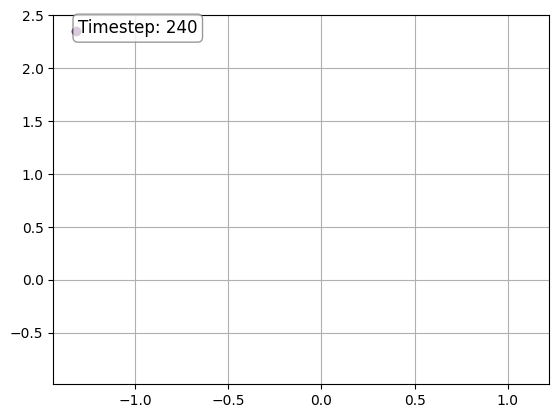

In [55]:
#@title

camera = Camera(plt.figure())

x0 = train_data_tf[:]
for timestep in range(0, num_diffusion_timesteps, 10):
  tstep = tf.repeat(tf.constant(timestep), (x0.shape[0]))
  shifted = diff_forward.q_sample(x0, tstep)
  plt.scatter(shifted[:,0], shifted[:,1], c=np.arange(x0.shape[0])//num_samples_per_center)
  plt.annotate(f'Timestep: {timestep}', xy=(0.05, 0.95), xycoords='axes fraction',
              fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
  plt.grid()
  camera.snap()

save_animation('scatter.mp4', 300)

In [56]:
show_video('scatter.mp4')